Written by Etienne Ndedi
Date: 10-10-2024

OBJECTIVE: TRAIN A NAIVE BAYES BINARY CLASSIFICATION MODEL ON THE BIAS_UNBIAS SUBSET OF WIKI NEUTRALITY DATA

- Read our libraries

In [ ]:
import pandas as pd
import numpy as np
import csv
from sklearn import preprocessing
import spacy
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid",color_codes=True)
from sklearn import metrics
from sklearn import model_selection
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.metrics import classification_report


- Read and generate our splits. training and test sets

In [ ]:
import pandas as pd
import csv

bias_train_full = pd.read_csv("/content/bias_train_full.csv", on_bad_lines='skip', engine='python')


In [ ]:
#Create a data set that consists of two columns, df_inputs['plots'] a concatenation of df_inputs['src_raw'] and df_inputs['tgt_raw']
df_new = pd.DataFrame(columns=['plots', 'labels'])

#Create two data sets, one with df_inputs['src_raw'] another with df_inputs['tgt_raw']
df_src = bias_train_full['src_raw']
df_tgt = bias_train_full['tgt_raw']

#rename df_tgt to 'example'
df_tgt = df_tgt.rename('example') # Changed 'columns' to 'name' for Series
#create a variable df_tgt['label'] with value 0
df_tgt = df_tgt.to_frame() # Convert Series to DataFrame to add a new column
df_tgt['label'] = 0
#rename df_src to 'example'
df_src = df_src.rename('example') # Changed 'columns' to 'name' for Series
#create a variable df_src['label'] with value 1
df_src = df_src.to_frame() # Convert Series to DataFrame to add a new column
df_src['label'] = 1
# Concatenate df_src and df_tgt to have a larger data set that we will shuffle
# This data set bias_unbias will have both the positive and negative labels
bias_unbias = pd.concat([df_src, df_tgt])
# Shuffle the data set
bias_unbias_train = bias_unbias.sample(frac=1).reset_index(drop=True)

# Print the number of rows in the DataFrame
print(f"Number of rows in DataFrame: {len(bias_unbias_train)}")

# Print the number of columns in the DataFrame
print(f"Number of columns in DataFrame: {len(bias_unbias_train.columns)}")

# Print the counts of the label column
print(bias_unbias_train['label'].value_counts())

# Print the first few rows of the DataFrame
bias_unbias_train.head()

Number of rows in DataFrame: 239540
Number of columns in DataFrame: 2
label
1    119770
0    119770
Name: count, dtype: int64


,example,label
0,talend - global leader in open source integrat...,1
1,"unfortunately, many of these houses were demol...",1
2,"long beach has an excellent ""on-line news agen...",1
3,"tom wilkinson as james reid, britt's wealthy f...",0
4,he was a doctor of the university of montpelli...,1


 At this juncture there are no balancing issues as the plots columns and labels came from
two columns sourced from the same subset named biased.full

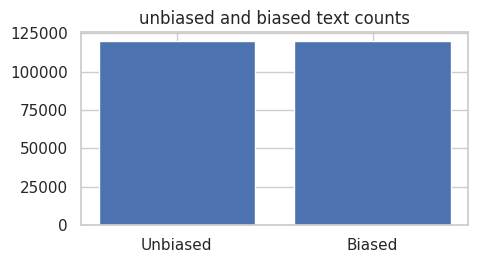

In [ ]:
label_names = ['Unbiased', 'Biased']
labels_names = bias_unbias_train['label'].value_counts()
title = 'unbiased and biased text counts'
plt.figure(figsize=(5,2.5))
plt.title(title)
plt.bar(label_names, labels_names)
plt.show()

In [ ]:
print(len(bias_unbias_train))

239540


Do same binarization massaging for test

In [ ]:
bias_test_full = pd.read_csv("/content/bias_test_full.csv", on_bad_lines='skip', engine='python')
len(bias_test_full)

25666

In [ ]:
#Create two data sets, one with df_inputs['src_raw'] another with df_inputs['tgt_raw']
df_src = bias_test_full['src_raw']
df_tgt = bias_test_full['tgt_raw']

#rename df_tgt to 'example'
df_tgt = df_tgt.rename('example') # Changed 'columns' to 'name' for Series
#create a variable df_tgt['label'] with value 0
df_tgt = df_tgt.to_frame() # Convert Series to DataFrame to add a new column
df_tgt['label'] = 0
#rename df_src to 'example'
df_src = df_src.rename('example') # Changed 'columns' to 'name' for Series
#create a variable df_src['label'] with value 1
df_src = df_src.to_frame() # Convert Series to DataFrame to add a new column
df_src['label'] = 1
# Concatenate df_src and df_tgt to have a larger data set that we will shuffle
# This data set bias_unbias will have both the positive and negative labels
bias_unbias_test = pd.concat([df_src, df_tgt])
# Shuffle the data set
bias_unbias_test = bias_unbias_test.sample(frac=1).reset_index(drop=True)

# Print the number of rows in the DataFrame
print(f"Number of rows in DataFrame: {len(bias_unbias_test)}")

# Print the number of columns in the DataFrame
print(f"Number of columns in DataFrame: {len(bias_unbias_test.columns)}")

# Print the counts of the label column
print(bias_unbias_test['label'].value_counts())

# Print the first few rows of the DataFrame
bias_unbias_test.head()

Number of rows in DataFrame: 51332
Number of columns in DataFrame: 2
label
1    25666
0    25666
Name: count, dtype: int64


,example,label
0,"some irish republicans, including cahir healy,...",1
1,"the state of north dakota , lacking anything e...",1
2,"of this, more than $3 million was donated prim...",1
3,"in a third incident, in spain, terrorists take...",0
4,"22 years younger than swift, it was obvious fr...",0


# No need to do the split as the test data is already available

In [ ]:
train_data = bias_unbias_train['example']
train_labels = bias_unbias_train['label']
test_data = bias_unbias_test['example']
test_labels = bias_unbias_test['label']

Now that I have my training and testing split we need to now use a TOKENIZER(spacy) on our data, to vectorize our text data.

Here we are using the Spacy

- I am going to first list a few pipe components; as I do not need then eliminate them. There should be no pipeline components

-  Then use the tokenizer

In [ ]:
#output will be pippes we do not need
nlp=spacy.load('en_core_web_sm')
nlp.pipe_names

['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']

In [ ]:
#ensure no more pipes
nlp = spacy.blank('en')
nlp.pipe_names

[]

Now the tokenizer. We need it to take tokens that include only alphabetic characters

In [ ]:
def spacy_tokenizer (sentence):
  return[t.text for t in nlp(sentence) if \
          not t.is_punct and\
          not t.is_space and\
          t.is_alpha]

Now we need to transform the text into a TfidVectorizer for feature vectors

In [ ]:
%%time
vectorizer = TfidfVectorizer(tokenizer = spacy_tokenizer)
train_feature_vects = vectorizer.fit_transform(train_data)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


CPU times: user 44.8 s, sys: 754 ms, total: 45.6 s
Wall time: 46 s


Now that we have the feature vectors we are ready to build A NAIVE BAYES model and see the internal parameters. This kicks off the training under the hood.

In [ ]:
nb_classifier = MultinomialNB()
nb_classifier.fit(train_feature_vects, train_labels)
nb_classifier.get_params()

{'alpha': 1.0, 'class_prior': None, 'fit_prior': True, 'force_alpha': True}

Let's now evaluate the Naive Bayes with an F1 score. We will ask the model to make prediction on our training set and see the best it can do

In [ ]:
train_preds=nb_classifier.predict(train_feature_vects)
print('F1 score on initial training set:{}'.format(metrics.f1_score(train_labels,train_preds,average = 'macro')))

F1 score on initial training set:0.6677634571839446


Because the F1 is low, we could see if something could be done to improve it. For instance characters that may still be appearing in the data.  So, we could consider removing these items if we find them (part of another EDA)

 Once the 2 items are removed we should retrain our model and make predictions on the training set. After this cleaning the following steps could be done:
  
*   do the train/validation split
*   regenerate the Tfidf vectors
*   retrain the model

FOR NOW, we will skip this this step and just jump to testing since 0.66 is not that bad considering we have additional models to run.

Now, I want to see how the model performs on the testing data. First I need to vectorize the data

In [ ]:
%%time
#vectorize the validation data
test_feature_vects = vectorizer.transform(test_data) #We should not call fit transform because we built the vocabulary already

#Now we want to predict and evaluate
test_preds =nb_classifier.predict(test_feature_vects)
print('F1 score on testing set before further cleaning (optional): {}'. format(metrics.f1_score(test_labels,test_preds, average = 'macro')))

F1 score on testing set before further cleaning (optional): 0.6387154435196514
CPU times: user 6.32 s, sys: 32.5 ms, total: 6.35 s
Wall time: 6.83 s


Since this is quite a drop in our F1 score going from 66% in the training set to 63% in the validation set. We need to see what is going on by using a tool like the confusion matrix

In [ ]:
ac = accuracy_score(test_labels, test_preds)
print("Accuracy: {:.2f}%".format(ac * 100))

Accuracy: 63.98%


In [ ]:
import tensorflow as tf # Import TensorFlow
from sklearn.metrics import confusion_matrix, accuracy_score

cm = confusion_matrix(test_labels, test_preds)
cm = cm / cm.sum(axis=1)[:, tf.newaxis]  # Normalize the confusion matrix
print(cm)

[[0.69344658 0.30655342]
 [0.41393283 0.58606717]]


In [ ]:
label_names = ['No Bias', 'Bias']
labels_names = bias_unbias['label'].value_counts()
print(labels_names)

label
1    119770
0    119770
Name: count, dtype: int64


Text(116.24999999999999, 0.5, 'True')

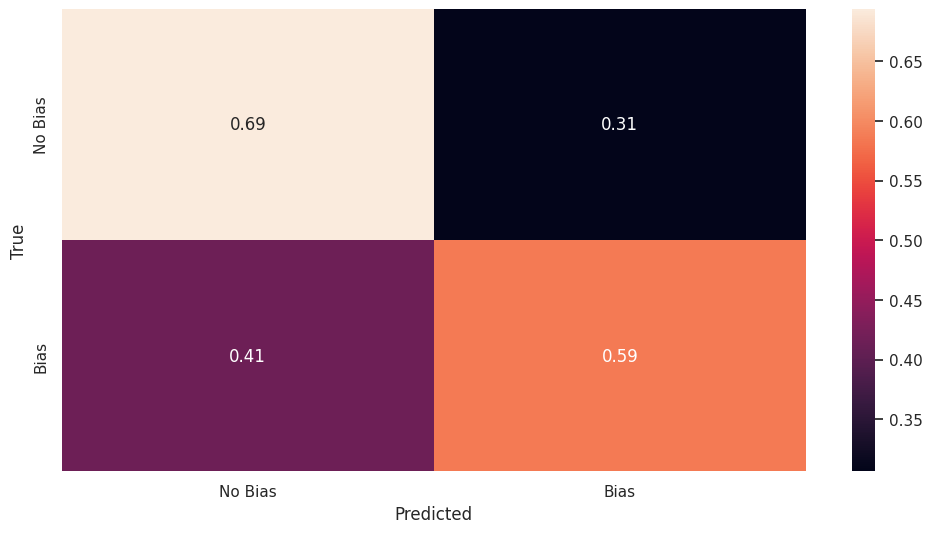

In [ ]:
plt.figure(figsize=(12,6))
sns.heatmap(
    cm, annot=True,
    xticklabels=label_names,
    yticklabels=label_names)
plt.xlabel("Predicted")
plt.ylabel("True")

Our Naive Bayes is a baseline model with a range of 59% to 69% of True Positives and accuracy score below 63.98% in testing; thus improvement is needed. We will now seek to use another classifier which we think has more predictive. First let's see how the model is doing on validation.

LET'S NOW TEST THE MODEL ON VALIDATION DATA

In [ ]:
bias_valid_full = pd.read_csv("/content/bias_val_full.csv", on_bad_lines='skip', engine='python')
len(bias_valid_full)

25665

In [ ]:
#Create two data sets, one with df_inputs['src_raw'] another with df_inputs['tgt_raw']
df_src = bias_valid_full['src_raw']
df_tgt = bias_valid_full['tgt_raw']

#rename df_tgt to 'example'
df_tgt = df_tgt.rename('example') # Changed 'columns' to 'name' for Series
#create a variable df_tgt['label'] with value 0
df_tgt = df_tgt.to_frame() # Convert Series to DataFrame to add a new column
df_tgt['label'] = 0
#rename df_src to 'example'
df_src = df_src.rename('example') # Changed 'columns' to 'name' for Series
#create a variable df_src['label'] with value 1
df_src = df_src.to_frame() # Convert Series to DataFrame to add a new column
df_src['label'] = 1
# Concatenate df_src and df_tgt to have a larger data set that we will shuffle
# This data set bias_unbias will have both the positive and negative labels
bias_unbias_valid = pd.concat([df_src, df_tgt])
# Shuffle the data set
bias_unbias_valid = bias_unbias_valid.sample(frac=1).reset_index(drop=True)

# Print the number of rows in the DataFrame
print(f"Number of rows in DataFrame: {len(bias_unbias_valid)}")

# Print the number of columns in the DataFrame
print(f"Number of columns in DataFrame: {len(bias_unbias_valid.columns)}")

# Print the counts of the label column
print(bias_unbias_valid['label'].value_counts())

# Print the first few rows of the DataFrame
bias_unbias_valid.head()

Number of rows in DataFrame: 51330
Number of columns in DataFrame: 2
label
0    25665
1    25665
Name: count, dtype: int64


,example,label
0,crossroads gps demonstrated its interest in pa...,0
1,it is only the eighth film ever to win eight a...,1
2,all romance languages (sometimes referred to a...,1
3,"however, throughout the course of the civil wa...",0
4,two other reports collated years after the inc...,1


In [ ]:
valid_data = bias_unbias_valid['example']
valid_labels = bias_unbias_valid['label']

Vectorize validation data and test

In [ ]:
%%time
#vectorize the validation data
valid_feature_vects = vectorizer.transform(valid_data) #We should not call fit transform because we built the vocabulary already

#Now we want to predict and evaluate
valid_preds =nb_classifier.predict(valid_feature_vects)
print('F1 score on validation set before further cleaning (optional): {}'. format(metrics.f1_score(valid_labels,valid_preds, average = 'macro')))

F1 score on validation set before further cleaning (optional): 0.640901573056323
CPU times: user 9.16 s, sys: 64.9 ms, total: 9.22 s
Wall time: 9.36 s


Let's go after the confusion matrix in this case as well.

In [ ]:
ac = accuracy_score(valid_labels, valid_preds)
print("Accuracy: {:.2f}%".format(ac * 100))

Accuracy: 64.19%
